<a href="https://colab.research.google.com/github/TirendazAcademy/NLP-with-Transformers/blob/main/Text-Analysis-with-Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis with Transformers using the Emotion Dataset
Text classification is a machine learning technique that uses to predict categories of open-ended text. Text classification is one of the most common tasks in NLP, allowing you to organize, structure and categorize almost any type of text from documents, medical research, files and anywhere on the web.

In this notebook, we'll analyze feedback from customers with the Twitter dataset, called the emotion dataset. We’ll overcome this task using a variant of BERT called DistilBERT. The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient. Let's start with installing the necessary libraries.

In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 31.8 MB/s 
     |████████████████████████████████| 182 kB 73.2 MB/s 
     |████████████████████████████████| 212 kB 27.4 MB/s 
     |████████████████████████████████| 132 kB 75.6 MB/s 
     |████████████████████████████████| 127 kB 54.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Loadind Dataset
To create our emotion detector, we’ll use the emotions dataset consisting of  English Twitter messages. This dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. 

Given a tweet, our goal is to train a model that can classify it into one of these emotions. We'll use Datasets to download the data from the Hugging Face Hub.

In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

# Data Preprocessing

As you can see, it is similar to a Python dictionary, with each key corresponding to a different split. This allows us to use the usual dictionary syntax to access an individual split:

In [3]:
train_ds = emotions["train"].shuffle(seed=42).select([i for i in list(range(5000))])
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})

This object is an instance of the Dataset class. Datasets are in a typed column format, which is more memory efficient than native Python.

Let's take a look at the first examples of this object.

In [5]:
train_ds[:5]

{'text': ['while cycling in the country',
  'i had pocket qq and was feeling pretty confident lol',
  'i am in no way complaining or whining or feeling ungrateful',
  'i feel a bit stressed because it feels like im supposed to do something all the time and that i should be reading now',
  'i tell the people closest to me things that i am feeling and its as if they arent surprised because theyd known it all along'],
 'label': [4, 1, 0, 3, 5]}

Next, let's take a look at the names of columns in the object and the shape of the train set. 

In [6]:
print("The names of the columns: ", train_ds.column_names)
print("The shape of the train set: ", train_ds.shape)

The names of the columns:  ['text', 'label']
The shape of the train set:  (5000, 2)


Let's take a look at the data types in the train dataset.

In [7]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


## How to load a dataset not on the hub?

You may want to work with data stored on your laptop or on a remote server in your organization. Datasets allows you to handle local and remote datasets. Let's first download the emotion dataset and then load this dataset in our runtime.

In [8]:
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}
!head -n 1 train.txt

--2022-12-01 13:05:40--  https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/1pzkadrvffbqw6o/train.txt [following]
--2022-12-01 13:05:40--  https://www.dropbox.com/s/raw/1pzkadrvffbqw6o/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5ba26c50597f8175cb8f2f64a3.dl.dropboxusercontent.com/cd/0/inline/BxwBj5USg9R6KnAI2TigZIf5omIJna1n8Y6HgzVJ4iRlB42_ZJm4RL_yae2wlxVCadFinnyVCGZ5_q_nqLTTGElJ_YPot_umXWUIO2M8l7xp2_wNRe-xsfZFMosaFzPr3b6zhsr3E5bZKPcS2dEPYH8CjhLuhwWB_7fsVj4iyMc8bQ/file# [following]
--2022-12-01 13:05:41--  https://uc5ba26c50597f8175cb8f2f64a3.dl.dropboxusercontent.com/cd/0/inline/BxwBj5USg9R6KnAI2TigZIf5omIJna1n8Y6HgzVJ4iRlB42_ZJm4RL_yae2wlxVCadFinnyVCGZ5_q_nqLTTGElJ_

As you can see, the dataset is in csv format. Let's load the dataset locally by using the csv script with the `data_files` argument.

In [9]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",  names=["text", "label"])
emotions_local

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b712c18179d3f572/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

You can also directly load the dataseti from source.

In [10]:
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", names=["text", "label"])
emotions_remote

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-88a3a10ec1a82da2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

## From Datasets to DataFrames

If you are familiar with Pandas for preprocessing and visualizing the dataset, you can convert the dataset to DataFrame with the `set_format()` method. Keep in mind that this does not change the underlying data format and you can switch to another format later if you want:

In [11]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As you can see the labels represent numbers. You can also add labels corresponding to the numbers with the `int2str()` method.

In [12]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Understanding the Dataset

Let's take a look at the class distribution:

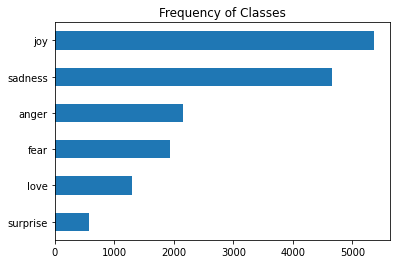

In [13]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and surprise are about 5–10 times rarer. You can overcome this problem with the [`Imbalanced-learn library`](https://imbalanced-learn.org/stable/). 

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. Let's take a look at the sequence lenghts of tweets.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


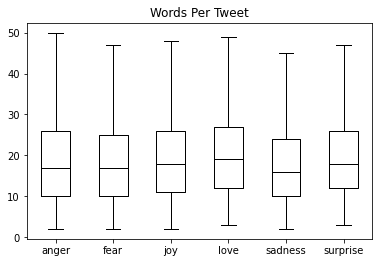

In [14]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

As you can see taht most tweets are around 15 words long and the longest tweets are well below DistilBERT’s maximum context size. 

Let’s now show how we can convert these raw texts into a format suitable for ​nlpt_pin01⁠ Transformers! First, let’s also reset the output format of our dataset since we don’t need the DataFrame format anymore:

In [15]:
emotions.reset_format()

## From Text to Tokens
Transformer models cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model.

To perform tokenization you can use `from_pretrained()` method in the `AutoTokenizer` class. This class let you quickly load the tokenizer associated with a pretrained model. 

In [16]:
!pip install transformers
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 25.5 MB/s 
     |████████████████████████████████| 7.6 MB 77.5 MB/s 


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

The AutoTokenizer class automatically retrieve the model’s configuration, pretrained weights, or vocabulary from the name of the checkpoint.

Let's tokenize the whole dataset the `map()` method. The first thing we need is a processing function to tokenize our examples with:

In [17]:
def preprocess_function(examples):
   return tokenizer(examples["text"], padding=True, truncation=True)

print(preprocess_function(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here [101] and [102] denote [CLS] and [SEP], respectively, which denote the beginning and end of the sequence. Once we’ve defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [18]:
emotions_encoded = emotions.map(preprocess_function, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we’ve set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This provides that the input tensors and attention masks have the same shape globally, 

In [19]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Training a Text Classifier

Here are two options to train such a model on our Twitter dataset:

- Feature extraction
We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

- Fine-tuning
We train the whole model end-to-end, which also updates the parameters of the pretrained model.

Let's take a look at these approaches:

## Transformers as Feature Extractors

This approach is fairly simple. We freeze the body’s weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model.

To show this approach, let's use a pretrained model with the `AutoModel` class. The `AutoModel` class has a from_pretrained() method to load the weights of a pretrained model. You can train the model on the GPU if you have one as the following:

In [20]:
from transformers import AutoModel
import torch 

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's create a function to extract the hidden states.

In [21]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

Since our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format, as follows:

In [22]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Let's extract the hidden states across all splits in one go:

In [23]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

So applying the `extract_​hid⁠den_​states()` function has added a new hidden_state column to our dataset:

In [24]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them. The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-learn format as follows:

In [25]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Let's train a simple classifier to compare our model.

In [26]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it’s actually significantly better.

## Fine-Tuning Transformers

With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them.

This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification. We’ll be using the Trainer API from nlpt_pin01 Transformers to simplify the training loop. Let’s look at the ingredients we need to set one up! 

Let's load the pretrained DistilBERT with the `AutoModelForSequenceClassification` that has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

To do this you just need to specify how many labels the model has to predict (six in our case).

In [27]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi


To monitor metrics during training, let's define a `compute_metrics()` function for the Trainer.

In [28]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the Trainer class:

- Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.

- Define all the hyperparameters for the training run.

If you’re running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:

In [29]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


To define the training parameters, we use the `TrainingArguments` class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is `output_dir`, which is where all the artifacts from training are stored. Here is an example of `TrainingArguments` in all its glory:

In [30]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

Let's instantiate and fine-tune our model with the Trainer:

In [31]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/Tirendaz/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.866000,0.336506,0.896000,0.890510
2,0.262600,0.224259,0.925000,0.925147


As you can see that our model has an F1-score on the validation set of around 92% — this is a significant improvement over the feature-based approach!

Let's predict the validation set the `predict()` method that returns several useful objects we can use for evaluation:

In [32]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.22425858676433563,
 'test_accuracy': 0.925,
 'test_f1': 0.925147257862255,
 'test_runtime': 4.5615,
 'test_samples_per_second': 438.452,
 'test_steps_per_second': 7.015}

We can decode the predictions greedily using np.argmax(). This yields the predicted labels and has the same format as the labels returned by the Scikit-learn models in the feature-based approach:

In [33]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions, we can plot the confusion matrix:

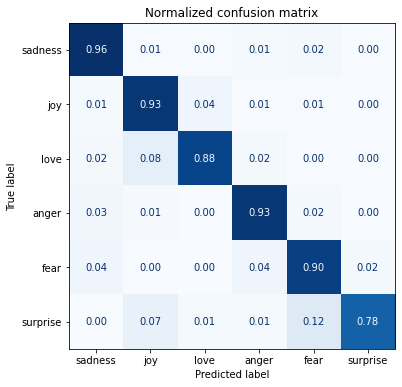

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

As you can see this is much closer to the ideal diagonal confusion matrix. The love category is still often confused with joy, which seems natural. surprise is also frequently mistaken for joy, or confused with fear. 

Overall the performance of the model seems quite good, but before we call it a day, let’s dive a little deeper into the types of errors our model is likely to make.

# Saving and sharing the model

You can share your models with others via the Hugging Face Hub with the `Trainer API`.

In [35]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Dec01_13-22-44_1bb94d3aba7f/events.out.tfevents.1669901036.1bb94d3aba7f.74.0:  63%|######3   …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Tirendaz/distilbert-base-uncased-finetuned-emotion
   61db442..d7a78c6  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Tirendaz/distilbert-base-uncased-finetuned-emotion
   61db442..d7a78c6  main -> main

To https://huggingface.co/Tirendaz/distilbert-base-uncased-finetuned-emotion
   d7a78c6..15e4802  main -> main

   d7a78c6..15e4802  main -> main



'https://huggingface.co/Tirendaz/distilbert-base-uncased-finetuned-emotion/commit/d7a78c64feb6397b4db40c4ad17264ff2bea9fa3'

You can also use the fine-tuned model to make predictions on new tweets. Since you’ve pushed our model to the Hub, we can now use it with the `pipeline()` function:

In [36]:
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "Tirendaz/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Next, let’s test the pipeline with a sample tweet:

In [37]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Finally, we can plot the probability for each class in a bar plot.

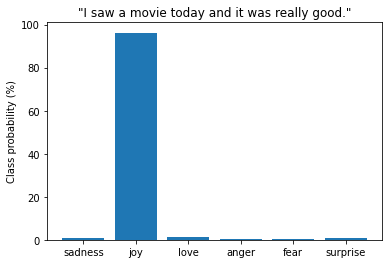

In [38]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

# Conclution

In this notebook we talked about how to train a transformer model to classify the emotions in tweets! 

# Resource:

- [Natural Language Processing with Transformers](https://github.com/nlp-with-transformers)

📌 Follow us on [YouTube](https://www.youtube.com/channel/UCFU9Go20p01kC64w-tmFORw) | [Twitter](https://twitter.com/TirendazAcademy) | [Instagram](https://www.instagram.com/tirendazacademy) | [Tiktok](https://www.tiktok.com/@tirendazacademy) | [Medium](https://tirendazacademy.medium.com) | [Reddit](https://www.reddit.com/user/TirendazAcademy) 